# Исходные данные

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Заказчик любезно предоставил нам 4 датасета:
- ****ct_new.csv — информация о договоре
- ****nal_new.csv — персональные данные клиента
- ****net_new.csv — информация об интернет-услугах
- ****one_new.csv — информация об услугах телефонии
    
Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

- BeginDate – дата начала пользования услугами
- EndDate – дата окончания пользования услугами
- Type – тип оплаты: ежемесячный, годовой и тд
- PaperlessBilling – безналичный расчет
- PaymentMethod – способ оплаты
- MonthlyCharges – ежемесячные траты на услуги
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – пенсионер(да/нет)
- Partner – семейный статус
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

In [1]:
pip install phik

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Библиотеки
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, cv, train
from sklearn.linear_model import LogisticRegression
import phik

from sklearn.dummy import DummyClassifier

random = 250923

import time
from warnings import simplefilter
simplefilter(action='ignore')

In [4]:
colours = ['#D0BBFF', '#FFFEA3'] 
def data_info(link, alt_link, data_name):
    try:
        data = pd.read_csv(alt_link)
    except:
        data = pd.read_csv(link)
    data.info()
    print()
    print('{}'.format(data_name))
    display(data.head(10))
    data.drop_duplicates() 
    return data 

In [5]:
contract = data_info('/datasets/****ct_new.csv', 'C:/Users/Ксения/data_analyst/DS_grad/****ct_new.csv', 'contract')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [6]:
contract['BeginDate']=contract['BeginDate'].astype('datetime64[ns]')
contract['EndDate']=contract.loc[contract['EndDate'] != 'No','EndDate'].astype('datetime64[ns]')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


In [7]:
internet = data_info('/datasets/****net_new.csv', 'C:/Users/Ксения/data_analyst/DS_grad/****net_new.csv', 'internet')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [8]:
personal = data_info('/datasets/****nal_new.csv', 'C:/Users/Ксения/data_analyst/DS_grad/****nal_new.csv', 'personal')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [9]:
phone = data_info('/datasets/****one_new.csv', 'C:/Users/Ксения/data_analyst/DS_grad/****one_new.csv', 'phone')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [10]:
# объединим датасеты
data = contract.merge(internet, on = 'customerID', how = 'outer')
data = data.merge(personal, on = 'customerID', how = 'outer')
data = data.merge(phone, on = 'customerID', how = 'outer')
data = data.drop_duplicates().reset_index(drop = True)
data.sample(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
2160,7101-HRBLJ,2014-02-01,NaT,Two year,Yes,Bank transfer (automatic),83.70,6026.4,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Female,0,Yes,Yes,No
6454,2669-QVCRG,2016-09-01,NaT,Month-to-month,Yes,Credit card (automatic),81.30,3333.3,Fiber optic,Yes,No,No,No,No,No,Female,0,No,No,Yes
4850,0931-MHTEM,2015-08-01,NaT,One year,Yes,Credit card (automatic),100.05,5402.7,Fiber optic,Yes,Yes,No,No,Yes,Yes,Female,0,No,No,No
1375,1839-FBNFR,2016-11-01,NaT,Two year,Yes,Bank transfer (automatic),19.85,774.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No
3720,1097-FSPVW,2016-08-01,NaT,Month-to-month,No,Credit card (automatic),54.55,2291.1,DSL,Yes,No,Yes,No,No,No,Female,0,No,No,No
5539,4632-PAOYU,2018-04-01,NaT,One year,No,Mailed check,19.95,456.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
3736,2926-JEJJC,2019-06-01,NaT,One year,Yes,Bank transfer (automatic),20.20,161.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,No,No
5246,1981-INRFU,2019-10-01,NaT,Month-to-month,Yes,Electronic check,79.75,319.0,Fiber optic,No,No,No,No,Yes,No,Female,0,No,No,No
6069,8097-OMULG,2015-03-01,2019-11-01,One year,No,Credit card (automatic),76.75,4469.92,DSL,No,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,No
6937,7746-AWNQW,2017-10-01,NaT,Month-to-month,Yes,Mailed check,35.75,1001.0,DSL,No,No,Yes,Yes,No,No,Female,0,No,No,NaN


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

Пропуски в объединенном датасете


customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

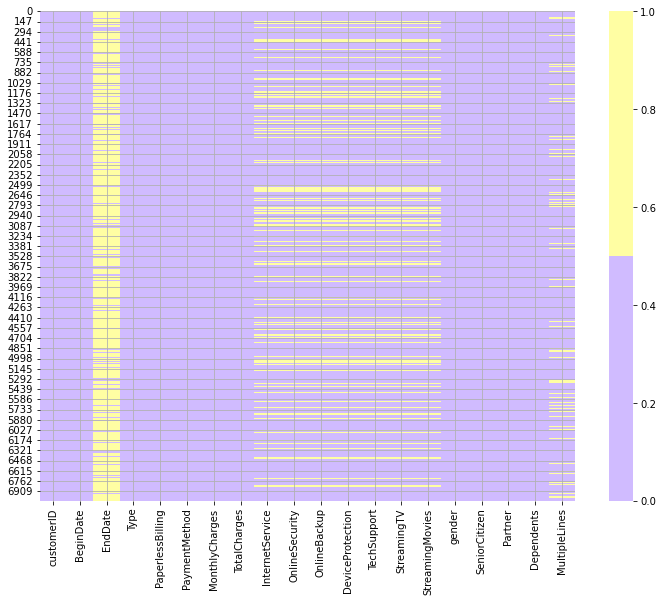

In [12]:
fig, ax = plt.subplots(figsize=(12,9))
print('Пропуски в объединенном датасете')
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))
plt.grid()
data.isna().sum()

In [13]:
isna_columns = ['InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [14]:
data.loc[data['TotalCharges'] == ' ', 'TotalCharges'] = data['MonthlyCharges']
data['TotalCharges'] = data['TotalCharges'].astype('float64')

Пропуски в объединенном датасете


customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines          0
dtype: int64

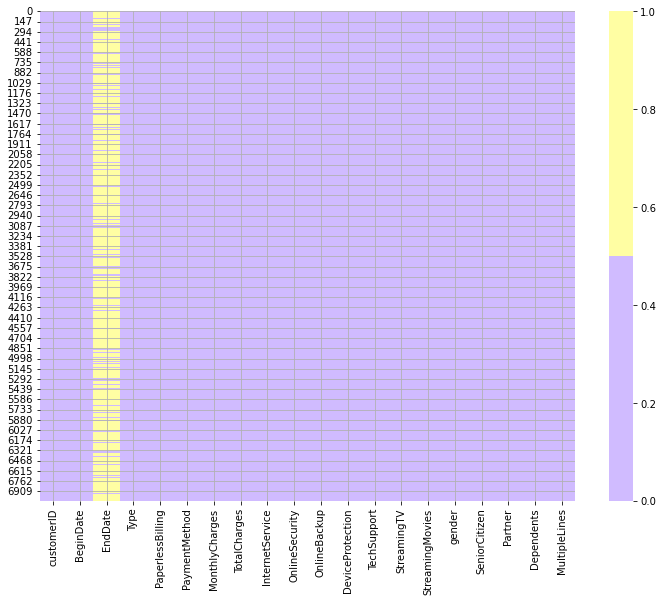

In [15]:
data[isna_columns] = data[isna_columns].fillna('nda')
fig, ax = plt.subplots(figsize=(12,9))
print('Пропуски в объединенном датасете')
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))
plt.grid()
data.isna().sum() 

In [16]:
data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines'],
      dtype='object')

In [17]:
#Посмотрим на адекватность булевых столбцов
boolean_columns = ['PaperlessBilling', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines']
data[boolean_columns].nunique()

PaperlessBilling    2
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
MultipleLines       3
dtype: int64

In [18]:
# Посмотрим распределение значений
other_columns = ['BeginDate', 'EndDate', 'Type', 
       'PaymentMethod', 'InternetService',
       'OnlineSecurity']

def distribution(column):
    title = 'График распределения значений столбца '+ column
    data.pivot_table(index=column, values='customerID', aggfunc='count').rename(
        columns = {'customerID': 'count'}).plot.bar(figsize=(16, 7), alpha =0.7, title =title)
    
    ax.set_ylabel('Кол-во значений')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show

    

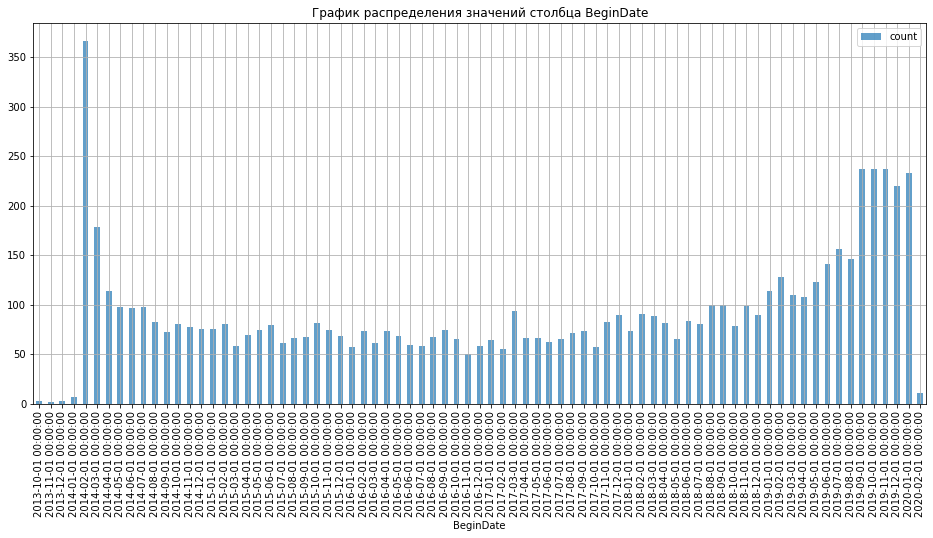

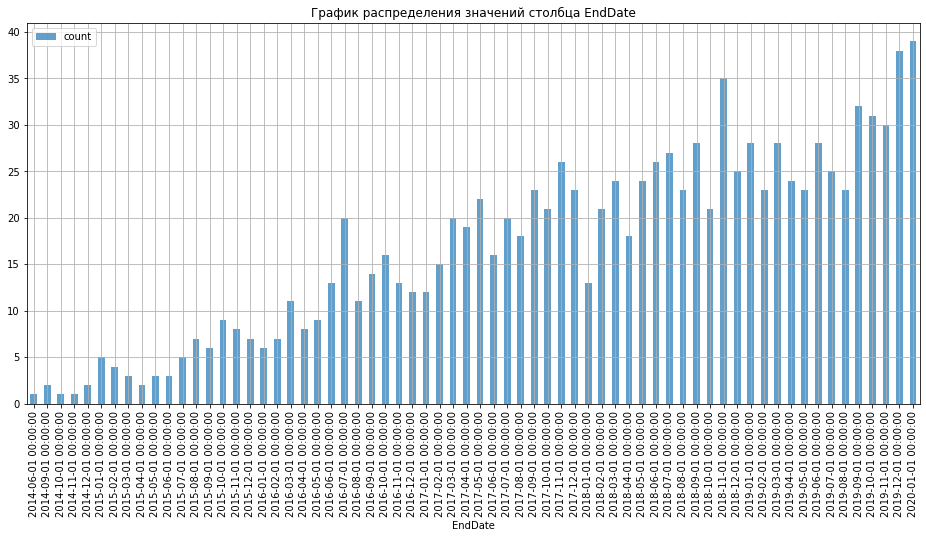

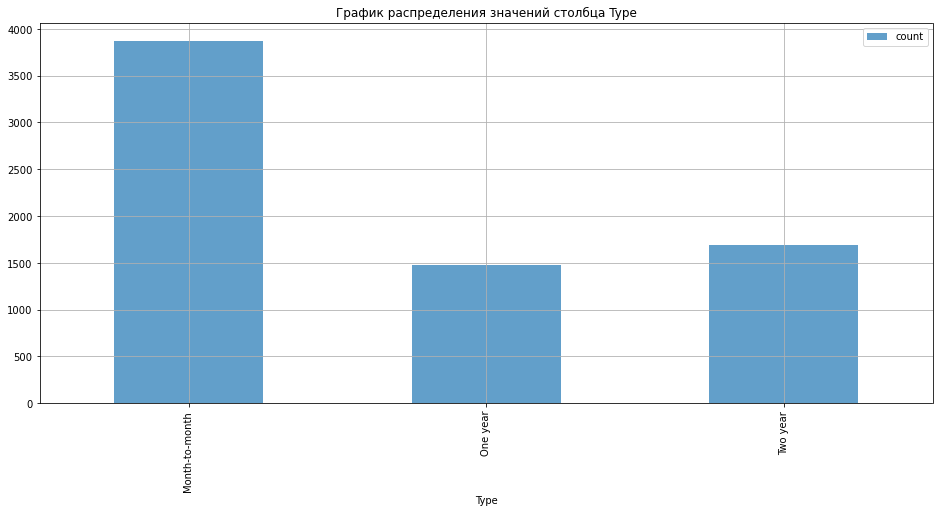

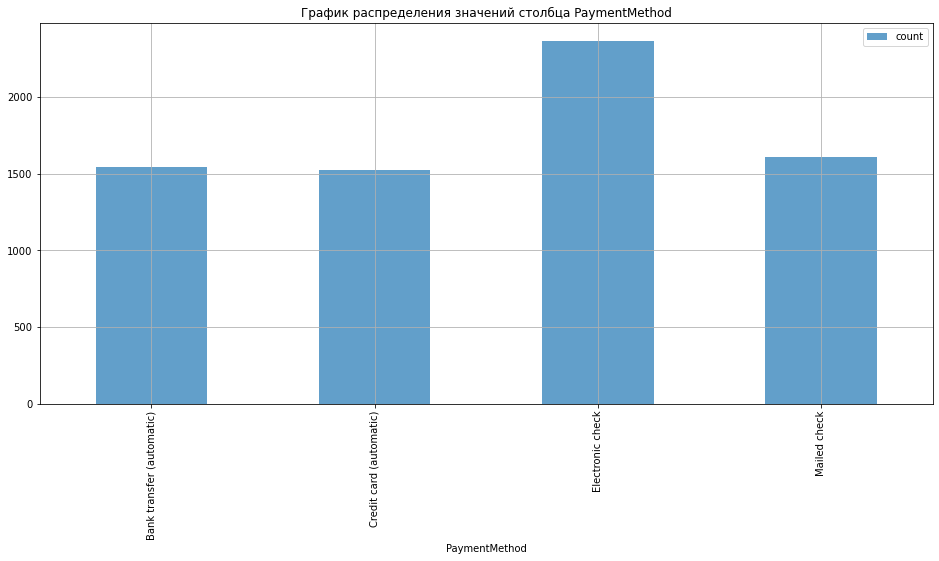

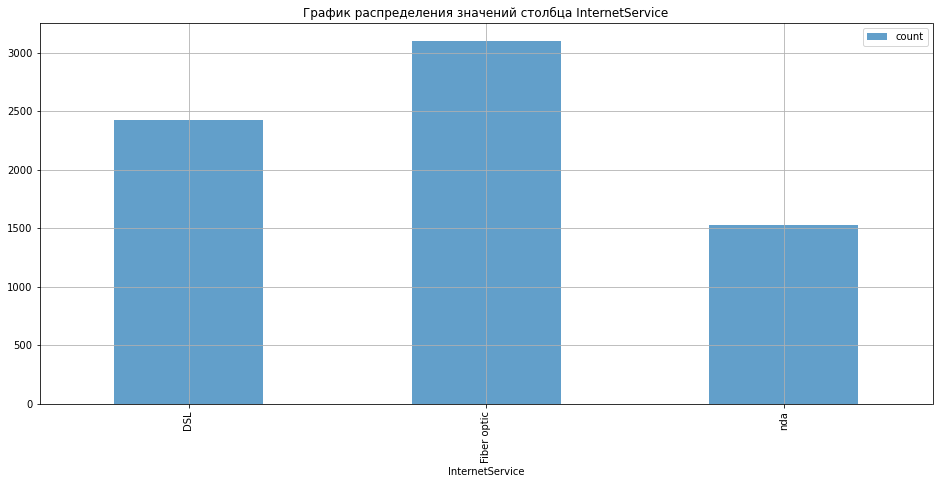

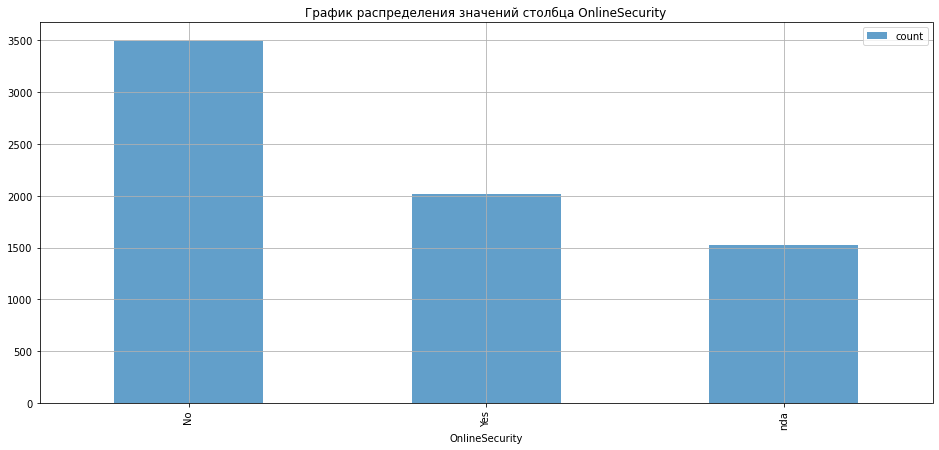

In [19]:
for i in other_columns:
    distribution(i)

In [20]:
data.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.377573,0.162147
std,30.090047,2112.678861,0.368612
min,18.250000,19.050000,0.000000
25%,35.500000,436.750000,0.000000
50%,70.350000,1343.350000,0.000000
75%,89.850000,3236.690000,0.000000
max,118.750000,9221.380000,1.000000


### Выводы.
В нашем распоряжении было 4 датасета:
- contract с информацией о договрах. Он состоит из 8 колонок и 7043 строки. Пропущенных значений не наблюдается, один из цифровых столбцов  имеет строковый тип данных. Изменения типа столбца будет после объединения в единый датафрейм. Столбцам с датами изменен тип данных на datime.


- internet датасет с данными об использовании интернет-услуг. В данном датасете по сути все данные кроме customerID имеют булевое значение, то есть все 2 варианта ответа. Датасет состоит из 8 колонок и  5517 строк. Пропусков в данных не наблюдается, формат данных соответствует.


- personal датасет с персональными данными клиента. Состоит из  5 колонок  и 7043 строк. Также как и у internet, данные имеют булевое значение. 

- phone датасет с  данными об услугах телефонии, состоящий из 2 колонок и 6361 строк. Пропусков в данных не наблюдается.


Датафреймы были объединены в единый большой датафрем путем вхождения всех данных(outer), вследствии чего появились пропуски.
Пропуски в столбце `TotalCharges` заменены на значения из столбца `MonthlyCharges` исходя из логики, что меньше этой суммы общие траты быть не могут и врзможно это первый месяц клиента, поэтому общие траты совпадают с месячными. 
Остальные пропуски в булевых столбцах принято решение заменить на `nda`, что означает no data available(нет данных). Такое решение является оптимальным и не искозит картину поведения клиентов с теми или иными признаками.
Таким образом в булевых столбцах, имеющих пропуски появилось третие значение.

Построены графики распределения данных. Согласно графикам наблюдаем массовое открытие договоров в феврале 2014г, а вот закрытие договоров самое большое наблюдается с осени 2019 и плавно перетекает в зиму 2020г. Чаще всего клиенты оплачивают услуги помесячно  с использованием электронного чека. А вот услугами по онлайн защите большинство клиентов не пользуется.
Помесячные траты и общие траты выглядят вполне правдоподобно: минимальный платеж в месяц 18.2, средний около 65 и максимальный 118.8

# План дальнейшей работы


- [ ] Изучение исходных данных
- [ ] Вывод на основе исследования данных
- [ ] Предобработка данных
- [ ] Обработка данных перед расчетом модели(в том числе определение перечня актуальных признаков)
- [ ] Подбор и создание моделей(разбиение на выборки, , кодирование, выбор моделей, подбор гиперпараметров) 
- [ ] Тест выбранной модели  и ее анализ
- [ ] Вывод
- [ ] Отчет

In [ ]:
# Подготовка датасета
# Что имеем
data.info()

In [23]:
# Создадим целевой признак
data['activ_customer'] = 0
data.loc[data['EndDate'].isna()==True, 'activ_customer'] = 1
data.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,activ_customer
6598,6169-PGNCD,2015-05-01,NaT,Two year,Yes,Credit card (automatic),74.30,4235.10,DSL,Yes,...,Yes,Yes,Yes,No,Female,0,No,No,No,1
6560,9801-NOSHQ,2018-03-01,NaT,One year,No,Mailed check,19.80,491.83,nda,nda,...,nda,nda,nda,nda,Male,0,No,Yes,No,1
1950,9614-RMGHA,2014-07-01,2017-05-01,Month-to-month,Yes,Bank transfer (automatic),91.85,3403.96,Fiber optic,No,...,No,No,Yes,No,Male,0,Yes,No,Yes,0
356,3351-NGXYI,2018-10-01,NaT,Month-to-month,Yes,Electronic check,54.10,865.60,DSL,Yes,...,No,No,No,No,Female,1,No,No,Yes,1
2713,5996-DAOQL,2020-01-01,NaT,Month-to-month,Yes,Mailed check,20.45,21.47,nda,nda,...,nda,nda,nda,nda,Male,0,No,No,No,1
3273,7112-OPOTK,2017-02-01,NaT,Month-to-month,No,Electronic check,68.25,2457.00,Fiber optic,No,...,No,No,No,No,Male,0,No,No,No,1
6569,2229-DPMBI,2019-06-01,NaT,Two year,No,Mailed check,19.50,157.56,nda,nda,...,nda,nda,nda,nda,Female,0,Yes,Yes,No,1
6628,9979-RGMZT,2019-07-01,NaT,One year,Yes,Mailed check,94.05,671.52,Fiber optic,No,...,No,No,Yes,Yes,Female,0,No,No,No,1
1880,6474-FVJLC,2019-10-01,NaT,Month-to-month,Yes,Electronic check,86.00,344.00,Fiber optic,No,...,No,No,No,Yes,Male,0,No,No,Yes,1
1940,4890-VMUAV,2014-11-01,2018-07-01,One year,No,Electronic check,71.50,3146.00,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,Yes,0


<AxesSubplot:>

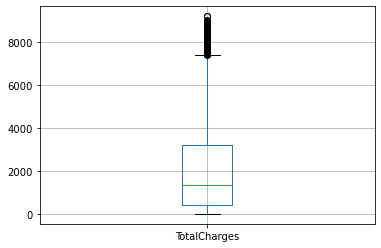

In [24]:
# Сделаем жинь проще, превратим платежи в категории
data[['TotalCharges']].boxplot()

<AxesSubplot:>

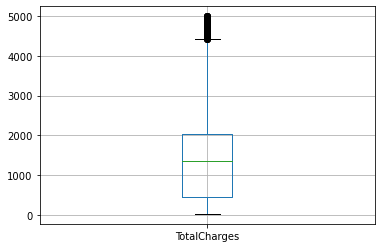

In [25]:
data.loc[data['TotalCharges']>5000, 'TotalCharges'] = data['TotalCharges'].median()
data[['TotalCharges']].boxplot()

<AxesSubplot:>

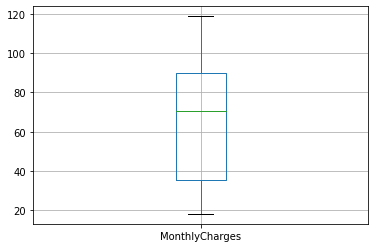

In [26]:
data[['MonthlyCharges']].boxplot()

In [27]:
data['MonthlyCharges_cat'] = data['MonthlyCharges']
data.loc[data['MonthlyCharges']<60, 'MonthlyCharges_cat'] = 'min'
data.loc[(data['MonthlyCharges']>=60) & (data['MonthlyCharges']<=80), 'MonthlyCharges_cat'] = 'mid'
data.loc[data['MonthlyCharges']>80, 'MonthlyCharges_cat'] = 'max'


data['TotalCharges_cat'] = data['MonthlyCharges']
data.loc[data['TotalCharges']<900, 'TotalCharges_cat'] = 'min'
data.loc[(data['TotalCharges']>=900) & (data['TotalCharges']<=1900), 'TotalCharges_cat'] = 'mid'
data.loc[data['TotalCharges']>1900, 'TotalCharges_cat'] = 'max'
data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,activ_customer,MonthlyCharges_cat,TotalCharges_cat
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,Female,0,Yes,No,nda,1,min,min
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,No,No,Male,0,No,No,No,1,min,max
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,Male,0,No,No,No,1,min,min
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,...,No,No,Male,0,No,No,nda,1,min,max
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,...,No,No,Female,0,No,No,No,1,mid,min
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,2035.20,DSL,Yes,...,Yes,Yes,Male,0,Yes,Yes,Yes,1,max,max
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,1343.35,Fiber optic,No,...,Yes,Yes,Female,0,Yes,Yes,Yes,1,max,mid
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,325.60,DSL,Yes,...,No,No,Female,0,Yes,Yes,nda,1,min,min
7041,8361-LTMKD,2019-07-01,NaT,Month-to-month,Yes,Mailed check,74.40,520.80,Fiber optic,No,...,No,No,Male,1,Yes,No,Yes,1,mid,min


In [28]:
# Предела совершенса не бывает, даты тоже будут категориями
report_day = pd.to_datetime('2020-02-01 00:00:00')
data['experience'] = data['EndDate'] - data['BeginDate']
data.loc[~data['experience'].isna(),'experience_days'] = np.round(data['experience'].dt.days/1,decimals = 0)
data.loc[data['experience'].isna(),'experience_days'] = np.round((report_day - data['BeginDate']).dt.days/1,decimals = 0)
data['experience_days'].unique()

array([  31., 1036.,  123., 1371.,  153.,  337.,  671.,  306.,  945.,
        882.,  396.,  488., 1767., 1614.,  761.,  670., 1584., 2163.,
        641.,   92.,  365., 1492., 1523., 2191.,  610., 1706.,   62.,
        822., 1764.,  245., 1401., 1095.,  427., 1948.,  518., 1918.,
       2102., 1310., 1826.,  580., 2010., 1432., 1246.,  549., 1949.,
       1888.,  914., 1279.,  276., 1067., 1461.,  883.,  881.,  792.,
       1157., 1581., 1280.,  973., 1248.,  184.,  215., 1006.,  853.,
       2041.,  702., 1737., 1857., 1979.,  457.,  884., 1431.,  485.,
       1034.,  975., 1551.,  700.,  942., 1734., 1798.,  730., 1340.,
       1216.,  943., 1066., 1096., 1645., 1642.,  273., 1553., 1219.,
        303., 1126., 1887., 2071.,  426., 2040.,  911., 2132., 1736.,
        640., 1489., 1675., 1218., 1522., 1186.,  608.,  214.,   59.,
         61.,    0., 1035., 1341., 1917., 1676., 1795., 1155.,  913.,
        182.,  820., 1430.,  976.,  579.,  669.,  486.,  668.,  760.,
       1611.,  912.,

In [29]:
display(data[['experience_days']].value_counts())
data[['experience_days']].astype('float').describe()

experience_days
2191.0             265
153.0              249
92.0               243
31.0               236
123.0              236
                  ... 
1402.0               1
336.0                1
305.0                1
1372.0               1
1887.0               1
Length: 251, dtype: int64

,experience_days
count,7043.000000
mean,898.555729
std,683.130510
min,0.000000
25%,276.000000
50%,761.000000
75%,1461.000000
max,2314.000000


In [30]:
# Удалим лишнее
data = data.drop(columns=['customerID', 'BeginDate', 'EndDate', 'experience'
                         ])
data.sample(10)



,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,activ_customer,MonthlyCharges_cat,TotalCharges_cat,experience_days
4141,Month-to-month,Yes,Electronic check,39.85,1408.70,DSL,No,No,Yes,No,...,No,Female,1,No,No,nda,1,min,mid,1067.0
2990,Month-to-month,Yes,Mailed check,33.90,203.40,DSL,No,No,No,No,...,Yes,Male,0,No,No,nda,0,min,min,184.0
4777,Month-to-month,No,Mailed check,51.55,106.19,DSL,No,Yes,No,No,...,No,Female,0,No,Yes,No,1,min,min,62.0
284,Month-to-month,No,Mailed check,95.15,475.75,Fiber optic,No,No,Yes,No,...,Yes,Male,0,Yes,Yes,No,0,max,min,153.0
2741,Month-to-month,Yes,Electronic check,89.50,805.50,Fiber optic,No,No,No,No,...,Yes,Male,1,No,No,No,1,max,min,276.0
5025,Month-to-month,Yes,Electronic check,69.80,418.80,Fiber optic,No,No,No,No,...,No,Male,0,Yes,Yes,No,1,mid,min,184.0
1588,One year,Yes,Electronic check,106.80,1343.35,Fiber optic,No,Yes,No,Yes,...,Yes,Female,1,No,No,Yes,1,max,mid,1523.0
5846,Month-to-month,No,Electronic check,76.10,228.30,Fiber optic,No,No,No,No,...,No,Female,0,No,No,Yes,1,mid,min,92.0
979,One year,Yes,Bank transfer (automatic),54.95,1813.35,DSL,Yes,No,No,Yes,...,No,Female,0,Yes,Yes,No,0,min,mid,1005.0
3548,One year,No,Credit card (automatic),97.65,1343.35,Fiber optic,Yes,No,No,Yes,...,Yes,Male,0,No,No,Yes,1,max,mid,2163.0


### Выводы
Итак сводный датасет претерпел некоторые изменения:
- создан самый главный целевой признак, который позволяет определить с нами ли клиент или же безвозвратно нас покинул. Маркировка `1` соответствует действующему договору, `0` - закрытому
- далее вводим категории для платежей `min`, `mid`, `max`
- введены 2 признака по длительности договора: в днях и месяцах. для действующих договоров посчитана длительность вплоть до дня выгрузки данных 1 февраля 2020
- были удалены столбцы, которые не нуж для дальнейшего построения модели

In [31]:
# Разделим на выборки

train, test  = train_test_split(data, test_size = 0.25, random_state = random, stratify=data[['activ_customer']])
print('Обучающая выборка:')
print(train.shape)
print('Тестовая выборка:')
print(test.shape)

Обучающая выборка:
(5282, 21)
Тестовая выборка:
(1761, 21)


In [32]:
train = train.reset_index(drop=True)
train.head(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,activ_customer,MonthlyCharges_cat,TotalCharges_cat,experience_days
0,Month-to-month,Yes,Electronic check,74.60,1865.00,Fiber optic,No,No,Yes,No,...,No,Female,0,Yes,No,No,1,mid,mid,761.0
1,One year,No,Electronic check,100.00,1900.00,Fiber optic,No,No,Yes,No,...,Yes,Male,0,Yes,Yes,Yes,0,max,mid,577.0
2,Two year,No,Bank transfer (automatic),105.50,1343.35,Fiber optic,Yes,Yes,No,Yes,...,Yes,Male,0,Yes,Yes,No,1,max,mid,2191.0
3,Two year,No,Bank transfer (automatic),90.55,2173.20,DSL,Yes,Yes,Yes,Yes,...,Yes,Male,0,Yes,No,Yes,0,max,max,731.0
4,Month-to-month,No,Credit card (automatic),48.55,728.25,DSL,Yes,No,No,No,...,No,Female,0,No,No,No,1,min,min,457.0
5,Month-to-month,No,Bank transfer (automatic),76.45,636.06,Fiber optic,Yes,No,No,No,...,No,Female,1,No,No,No,1,mid,min,245.0
6,One year,Yes,Bank transfer (automatic),91.00,1820.00,Fiber optic,No,No,No,No,...,Yes,Female,1,Yes,No,No,1,max,mid,610.0
7,Two year,Yes,Credit card (automatic),80.70,1371.90,DSL,No,Yes,Yes,Yes,...,Yes,Female,0,Yes,No,No,0,max,mid,518.0
8,Month-to-month,No,Mailed check,19.65,20.24,nda,nda,nda,nda,nda,...,nda,Female,0,No,No,No,1,min,min,31.0
9,Two year,No,Credit card (automatic),20.15,967.20,nda,nda,nda,nda,nda,...,nda,Male,0,No,No,No,1,min,mid,1461.0


In [33]:
test = test.reset_index(drop=True)
test.head(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,activ_customer,MonthlyCharges_cat,TotalCharges_cat,experience_days
0,Month-to-month,No,Electronic check,19.25,20.02,nda,nda,nda,nda,nda,...,nda,Female,0,Yes,Yes,No,1,min,min,31.0
1,One year,Yes,Electronic check,91.15,1343.35,Fiber optic,No,No,No,Yes,...,Yes,Female,0,Yes,No,Yes,1,max,mid,1614.0
2,Month-to-month,Yes,Mailed check,25.15,25.65,DSL,No,No,No,No,...,No,Female,0,No,No,nda,1,min,min,31.0
3,One year,No,Credit card (automatic),58.55,3688.65,DSL,No,No,Yes,No,...,Yes,Female,0,No,No,No,1,min,max,1918.0
4,Two year,Yes,Bank transfer (automatic),75.15,4133.25,DSL,Yes,Yes,Yes,No,...,Yes,Male,1,Yes,Yes,Yes,1,mid,max,1523.0
5,Month-to-month,Yes,Electronic check,86.50,951.50,Fiber optic,No,No,No,No,...,No,Female,0,Yes,No,Yes,1,max,mid,337.0
6,Two year,Yes,Bank transfer (automatic),84.70,1343.35,Fiber optic,Yes,Yes,No,No,...,No,Female,0,Yes,No,Yes,1,max,mid,2071.0
7,Two year,No,Mailed check,26.10,1879.20,nda,nda,nda,nda,nda,...,nda,Male,0,Yes,Yes,Yes,1,min,mid,2191.0
8,One year,Yes,Mailed check,81.15,579.41,DSL,Yes,No,Yes,Yes,...,Yes,Female,0,Yes,Yes,No,0,max,min,215.0
9,Month-to-month,Yes,Bank transfer (automatic),59.50,572.99,DSL,No,No,No,Yes,...,No,Female,0,No,No,No,1,min,min,276.0


In [34]:
cat_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 
       'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 
               'MonthlyCharges_cat', 'TotalCharges_cat'
              ]

In [35]:
# Функция группировки данных для графика
def hist(column, features):
    hist_group = features.groupby(['activ_customer', column]).agg({column: 'count'})
    hist_group.columns = ['number']
    hist_group = hist_group.reset_index()
    total_0 = hist_group[hist_group['activ_customer'] ==0]['number'].sum()
    total_1 = hist_group[hist_group['activ_customer'] ==1]['number'].sum()

    hist_group.loc[hist_group['activ_customer'] == 0, 'number'] = hist_group['number']/total_0 * 100
    hist_group.loc[hist_group['activ_customer'] == 1, 'number'] = hist_group['number']/total_1 * 100
    hist_group['number'] = round(hist_group['number'],2)
    return hist_group



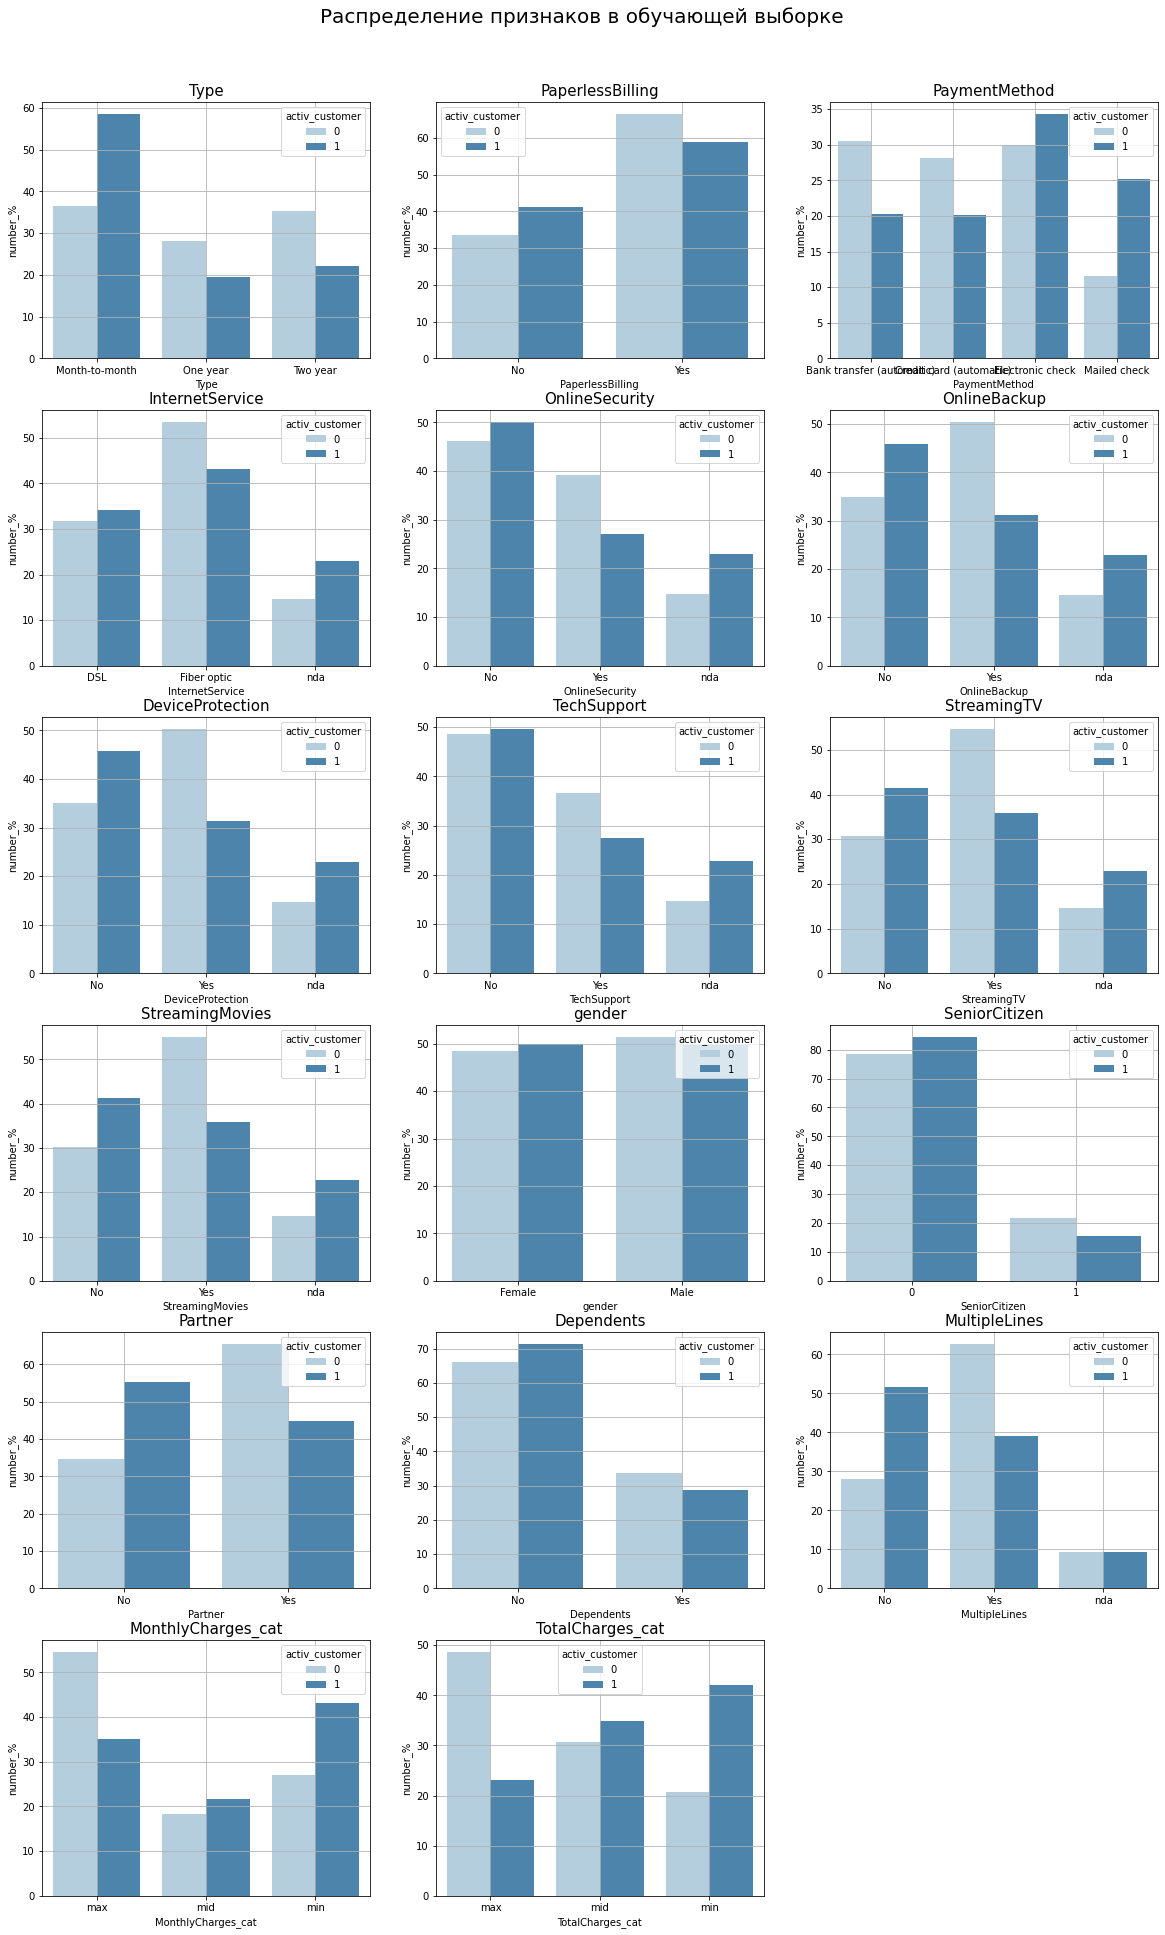

In [36]:
# Распределение признаков в обучающей выборке
fig = plt.figure(figsize=(20,33))
for k in range(1, (len(cat_columns)+1)): 
    fig.add_subplot(6, 3, k)
    hist_group = hist(cat_columns[k-1], train)
    sns.barplot(x = cat_columns[k-1], y = 'number' , hue='activ_customer', data = hist_group, palette="Blues", saturation=0.70)
    plt.grid(True)
    plt.ylabel('number_%')
    plt.title(cat_columns[k-1], fontsize=15)
fig.suptitle('Распределение признаков в обучающей выборке', fontsize=20,  y=0.92)
plt.show
None

In [37]:
features_train = train.drop(['activ_customer'], axis=1)
target_train=train['activ_customer']
features_test = test.drop(['activ_customer'], axis=1)
target_test=test['activ_customer']

In [38]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                5282 non-null   object 
 1   PaperlessBilling    5282 non-null   object 
 2   PaymentMethod       5282 non-null   object 
 3   MonthlyCharges      5282 non-null   float64
 4   TotalCharges        5282 non-null   float64
 5   InternetService     5282 non-null   object 
 6   OnlineSecurity      5282 non-null   object 
 7   OnlineBackup        5282 non-null   object 
 8   DeviceProtection    5282 non-null   object 
 9   TechSupport         5282 non-null   object 
 10  StreamingTV         5282 non-null   object 
 11  StreamingMovies     5282 non-null   object 
 12  gender              5282 non-null   object 
 13  SeniorCitizen       5282 non-null   int64  
 14  Partner             5282 non-null   object 
 15  Dependents          5282 non-null   object 
 16  Multip

In [39]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                1761 non-null   object 
 1   PaperlessBilling    1761 non-null   object 
 2   PaymentMethod       1761 non-null   object 
 3   MonthlyCharges      1761 non-null   float64
 4   TotalCharges        1761 non-null   float64
 5   InternetService     1761 non-null   object 
 6   OnlineSecurity      1761 non-null   object 
 7   OnlineBackup        1761 non-null   object 
 8   DeviceProtection    1761 non-null   object 
 9   TechSupport         1761 non-null   object 
 10  StreamingTV         1761 non-null   object 
 11  StreamingMovies     1761 non-null   object 
 12  gender              1761 non-null   object 
 13  SeniorCitizen       1761 non-null   int64  
 14  Partner             1761 non-null   object 
 15  Dependents          1761 non-null   object 
 16  Multip

interval columns not set, guessing: ['SeniorCitizen']


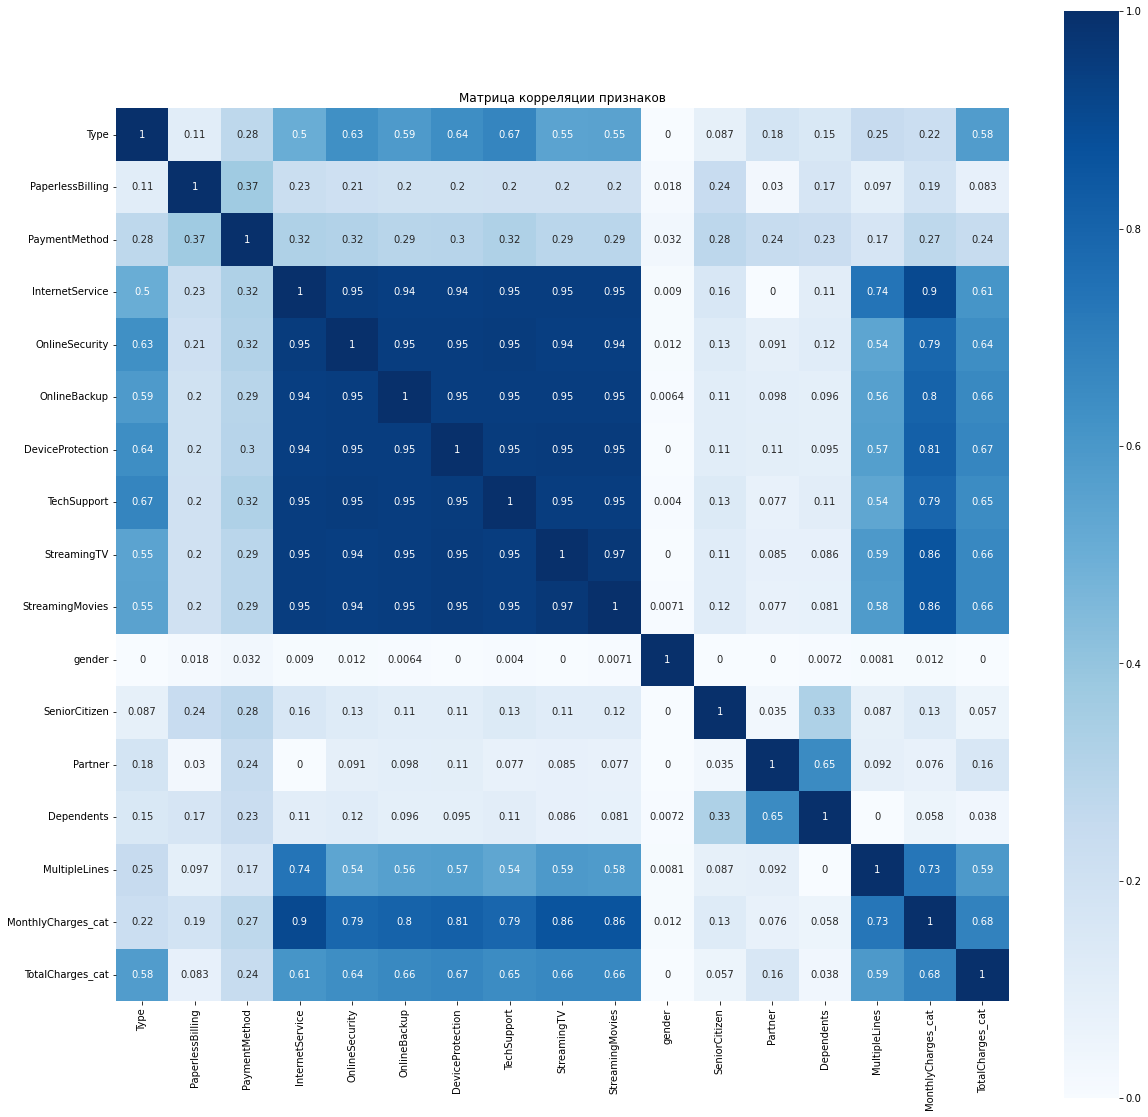

In [40]:
#phik_matrix
plt.figure(figsize=(20,20))
sns.heatmap(features_train[cat_columns].phik_matrix(), vmax=1, square=True,annot=True,cmap='Blues')
plt.title('Матрица корреляции признаков')
plt.show()

In [41]:
# Столбцы с большой корреляцией, на выброс
drop_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies']

In [42]:
features_train = features_train.drop(columns = drop_columns, axis =1)
features_test = features_test.drop(columns = drop_columns, axis =1)
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                5282 non-null   object 
 1   PaperlessBilling    5282 non-null   object 
 2   PaymentMethod       5282 non-null   object 
 3   MonthlyCharges      5282 non-null   float64
 4   TotalCharges        5282 non-null   float64
 5   gender              5282 non-null   object 
 6   SeniorCitizen       5282 non-null   int64  
 7   Partner             5282 non-null   object 
 8   Dependents          5282 non-null   object 
 9   MultipleLines       5282 non-null   object 
 10  MonthlyCharges_cat  5282 non-null   object 
 11  TotalCharges_cat    5282 non-null   object 
 12  experience_days     5282 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 536.6+ KB


interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'experience_days']


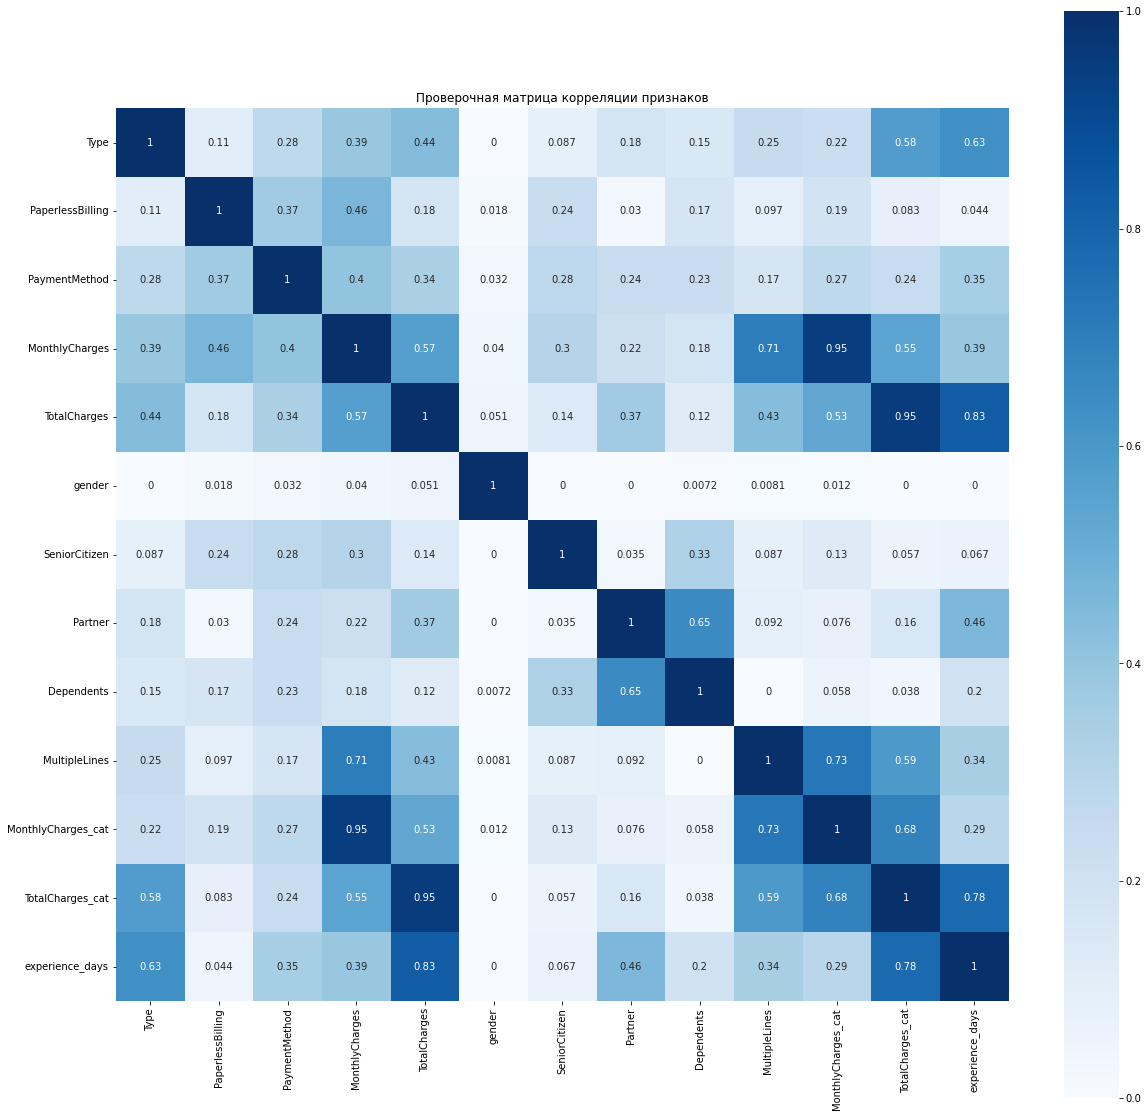

In [43]:
#phik_matrix
plt.figure(figsize=(20,20))
sns.heatmap(features_train.phik_matrix(), vmax=1, square=True,annot=True,cmap='Blues')
plt.title('Проверочная матрица корреляции признаков')
plt.show()

In [44]:
join_columns = ['MonthlyCharges', 'TotalCharges', 'experience_days'#, 'SeniorCitizen'
               ]

In [45]:
cat_columns_new= ['Type', 'PaperlessBilling', 'PaymentMethod', 
              'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 
               'MonthlyCharges_cat', 'TotalCharges_cat'
              ]

In [46]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                5282 non-null   object 
 1   PaperlessBilling    5282 non-null   object 
 2   PaymentMethod       5282 non-null   object 
 3   MonthlyCharges      5282 non-null   float64
 4   TotalCharges        5282 non-null   float64
 5   gender              5282 non-null   object 
 6   SeniorCitizen       5282 non-null   int64  
 7   Partner             5282 non-null   object 
 8   Dependents          5282 non-null   object 
 9   MultipleLines       5282 non-null   object 
 10  MonthlyCharges_cat  5282 non-null   object 
 11  TotalCharges_cat    5282 non-null   object 
 12  experience_days     5282 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 536.6+ KB


In [47]:
# Кодировка
onehotencoder = OneHotEncoder(sparse = False, handle_unknown='ignore')
features_train_1 = pd.DataFrame(onehotencoder.fit_transform(features_train[cat_columns_new]))
onehotencoder.get_feature_names_out()
features_train_1.columns = onehotencoder.get_feature_names_out()
features_train = features_train_1.join(train[join_columns], how = 'left')

features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Type_Month-to-month                      5282 non-null   float64
 1   Type_One year                            5282 non-null   float64
 2   Type_Two year                            5282 non-null   float64
 3   PaperlessBilling_No                      5282 non-null   float64
 4   PaperlessBilling_Yes                     5282 non-null   float64
 5   PaymentMethod_Bank transfer (automatic)  5282 non-null   float64
 6   PaymentMethod_Credit card (automatic)    5282 non-null   float64
 7   PaymentMethod_Electronic check           5282 non-null   float64
 8   PaymentMethod_Mailed check               5282 non-null   float64
 9   gender_Female                            5282 non-null   float64
 10  gender_Male                              5282 no

In [48]:
features_test_1 = pd.DataFrame(onehotencoder.transform(features_test[cat_columns_new]))
features_test_1.columns = features_train_1.columns
features_test = features_test_1.join(test[join_columns], how = 'left')
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Type_Month-to-month                      1761 non-null   float64
 1   Type_One year                            1761 non-null   float64
 2   Type_Two year                            1761 non-null   float64
 3   PaperlessBilling_No                      1761 non-null   float64
 4   PaperlessBilling_Yes                     1761 non-null   float64
 5   PaymentMethod_Bank transfer (automatic)  1761 non-null   float64
 6   PaymentMethod_Credit card (automatic)    1761 non-null   float64
 7   PaymentMethod_Electronic check           1761 non-null   float64
 8   PaymentMethod_Mailed check               1761 non-null   float64
 9   gender_Female                            1761 non-null   float64
 10  gender_Male                              1761 no

### Выводы
Продолжаем разговор...
Данные поделены на выборки согласно ТЗ в соотношении 75% обучающая и 25% тестовая.
Построены графики распределения признаков в разрезе статуса договора, сильных перекосов не наблюдается, данные выглядят вполне правдоподобно. Для дальнейшего построения модели категориальные признаки были закодированны. 
Проведен контроль датасета на колиниарность принаков. Признаки доп.услуг показали достаточно высокую зависимость. Для дальнейшей работы эти признакибыли удалены. Преднамеренно оставлены признаки категорий платежей общих и месячных, они показывают высокую корреляцию, что является логичным. Датасет готов к подбору моделей.

In [49]:
# Функция для дивных графиков

def roc_line(predict_proba, target, predict):
    
    fpr, tpr, thresholds = roc_curve(target, predict_proba[:, 1]) 
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
    ax1, ax2 = ax.flatten()
   
  
    # ROC-кривая случайной модели (выглядит как прямая)
    ax1.plot(fpr, tpr, linestyle='--', label=f'ROC curve (S={roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1])
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.0])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title("ROC-кривая")
    ax1.legend()
   
    
  
    print(f'Количество записей: {target.shape[0]}\n')

    cf_matrix = confusion_matrix(predict, target)

    ax2 = sns.heatmap(cf_matrix, annot= True , fmt="d",  cmap='Blues')

    ax2.set_title('Матрица ошибок\n');
    ax2.set_xlabel('\nПредсказание')
    ax2.set_ylabel('Истина ');


    ax2.xaxis.set_ticklabels(['False','True'])
    ax2.yaxis.set_ticklabels(['False','True'])
    
    
    
    plt.show()

In [50]:
# Модель Случайных дров
start_time = time.time()
model_rf= RandomForestClassifier(random_state = random)
parametrs = { 'n_estimators': range (0, 200),
              'max_depth': [None, range (1,25)],
              'min_samples_leaf': range (1,25),
              #'criterion': ['gini', 'entropy'],
              #'min_samples_split': range(1, 28),
               'max_features': [None, 'sqrt', 'log2']  
             
            }

grid_rf = RandomizedSearchCV(model_rf, parametrs, cv=6, n_jobs =-1, scoring='roc_auc', n_iter=200, random_state = random)

model_rf = grid_rf.fit(features_train,target_train)

finish_time = time.time()
train_time_rf = round(finish_time-start_time, 2)
print('Модель RandomForestClassifier ')
print ("Расчетное время обучения", train_time_rf)

print('Гиперпараметры модели:\n', grid_rf.best_params_)
print("Best Cross-Validation Score:", grid_rf.best_score_)
print()


#ВСЕ ЧТО НИЖЕ В ЯЧЕЙКЕ - УБИРАЕМ (ТАКЖЕ ДЕЛАЕМ В ДРУГИХ МОДЕЛЯХ ПО АНАЛОГИИ)


#predict_rf = model_rf.predict(features_train)

# вычислим вероятность положительного класса для всех моделей
#prob_rf = model_rf.predict_proba(features_train)

#вычислим значение auc_roc
#auc_roc_rf = roc_auc_score(target_train, prob_rf[:, 1])
#acc_rf = accuracy_score(target_train, predict_rf)

#print("AUC_ROC:", auc_roc_rf)
#print("ACC:", acc_rf)


#roc_line(prob_rf, target_train, predict_rf)

Модель RandomForestClassifier 
Расчетное время обучения 221.57
Гиперпараметры модели:
 {'n_estimators': 45, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'max_depth': None}
Best Cross-Validation Score: 0.8234940950880025



In [51]:
start_time = time.time()
model_CB = CatBoostClassifier(random_seed = random, verbose=False)

parametrs = {
            #'thread_count': range(1,15)
            #'iterations': range(1, 300,3)
            'custom_loss': ['AUC', 'Accuracy']
            #,'scale_pos_weight': range(1, 50,2)
            ,'learning_rate': [0.01, 0.03, 0.02]
            ,'depth': range(1, 12)
    }
        
grid_cb = RandomizedSearchCV(model_CB, parametrs, cv=2, n_jobs =-1, scoring='roc_auc', n_iter=100, random_state = random)
model_cb = grid_cb.fit(features_train, target_train)
finish_time = time.time()
train_time_cb = round(finish_time-start_time, 2)
print('Модель CatBoostClassifier')
print ("Расчетное время обучения", train_time_cb)

print('Гиперпараметры модели:\n', grid_cb.best_params_)
print("Best Cross-Validation Score:", grid_cb.best_score_)
print()


Модель CatBoostClassifier
Расчетное время обучения 746.91
Гиперпараметры модели:
 {'learning_rate': 0.03, 'depth': 5, 'custom_loss': 'AUC'}
Best Cross-Validation Score: 0.8724048104468334



In [52]:
start_time = time.time()
knn = KNeighborsClassifier()
start_time = time.time()
parametrs = {
            'n_neighbors' : range(1,31),
            'weights': ['uniform', 'distance'],
            'algorithm': ['ball_tree', 'kd_tree', 'brute']
                         
    }
grid_kn = RandomizedSearchCV(knn, parametrs, cv=6, n_jobs =-1, scoring='roc_auc', n_iter=200, random_state = random)
model_kn = grid_kn.fit(features_train, target_train)
finish_time = time.time()
train_time_kn = round(finish_time-start_time, 2)
print('Модель KNeighborsClassifier')
print ("Расчетное время обучения", train_time_kn)

print('Гиперпараметры модели:\n',grid_kn.best_params_)
print("Best Cross-Validation Score:", grid_kn.best_score_)
print()
predict_kn = model_kn.predict(features_train)


Модель KNeighborsClassifier
Расчетное время обучения 11.84
Гиперпараметры модели:
 {'weights': 'uniform', 'n_neighbors': 30, 'algorithm': 'ball_tree'}
Best Cross-Validation Score: 0.7395338437773455



In [53]:
start_time = time.time()
model_lr = LogisticRegression(random_state = random)
parametrs = { 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            #'max_iter': range(1, 200)
}
grid_lr = RandomizedSearchCV(model_lr, parametrs, cv=6, scoring='roc_auc', random_state = random)
model_lr= grid_lr.fit(features_train, target_train)
finish_time = time.time()
train_time_lr = round(finish_time-start_time, 2)
print('Модель LogisticRegression')
print ("Расчетное время обучения", train_time_lr)


print('Гиперпараметры модели:\n',grid_lr.best_params_)
print("Best Cross-Validation Score:", grid_lr.best_score_)
print()

Модель LogisticRegression
Расчетное время обучения 11.19
Гиперпараметры модели:
 {'solver': 'newton-cg'}
Best Cross-Validation Score: 0.7904634518489583



In [54]:
columns=['cross_validation']

pivot = pd.DataFrame(columns = columns
                               , index = ['RandomForestClassifier', 'CatBoostClassifier'
                                          ,'KNeighborsClassifier', 'LogisticRegression'])
pivot['cross_validation'] = grid_rf.best_score_, grid_cb.best_score_, grid_kn.best_score_, grid_lr.best_score_
pivot['cross_validation'] = round(pivot['cross_validation'], 3 )
pivot['время_обучения'] = train_time_rf, train_time_cb, train_time_kn, train_time_kn

pivot = pivot.reset_index()

pivot

,index,cross_validation,время_обучения
0,RandomForestClassifier,0.823,221.57
1,CatBoostClassifier,0.872,746.91
2,KNeighborsClassifier,0.740,11.84
3,LogisticRegression,0.790,11.84


### Вывод
Для поиска оптимальных метрик проверялись 4 модели:

- RandomForestClassifier
{'n_estimators': 45, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'max_depth': None}

- CatBoostClassifier
{'learning_rate': 0.03, 'depth': 5, 'custom_loss': 'AUC'}

- KNeighborsClassifier
{'weights': 'uniform', 'n_neighbors': 30, 'algorithm': 'ball_tree'}

- LogisticRegression
{'solver': 'newton-cg'}

Лучшей моделью оказалась CatBoostClassifier, на тест возьмем именно ее.

In [55]:
# Константная модель
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train)
model_dummy_pred = dummy_model.predict(features_test)
acc_dummy = accuracy_score(target_test, model_dummy_pred)
auc_ro_dummy = roc_auc_score(target_test, model_dummy_pred)

print("AUC_ROC:", auc_ro_dummy)
print("ACC:", acc_dummy)


AUC_ROC: 0.5
ACC: 0.8438387279954571


AUC_ROC: 0.9019625596476202
ACC: 0.8989210675752414
Количество записей: 1761



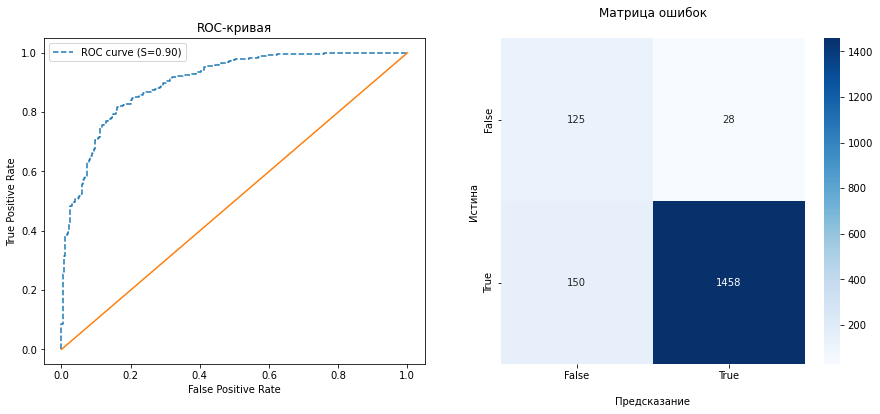

In [56]:
#Проверка лучшей модели
predict= model_cb.predict(features_test)

# вычислим вероятность положительного класса для всех моделей
prob = model_cb.predict_proba(features_test)

#вычислим значение auc_roc
auc_roc = roc_auc_score(target_test, prob[:, 1])
acc = accuracy_score(target_test, predict)

print("AUC_ROC:", auc_roc)
print("ACC:", acc)


roc_line(prob, target_test, predict)

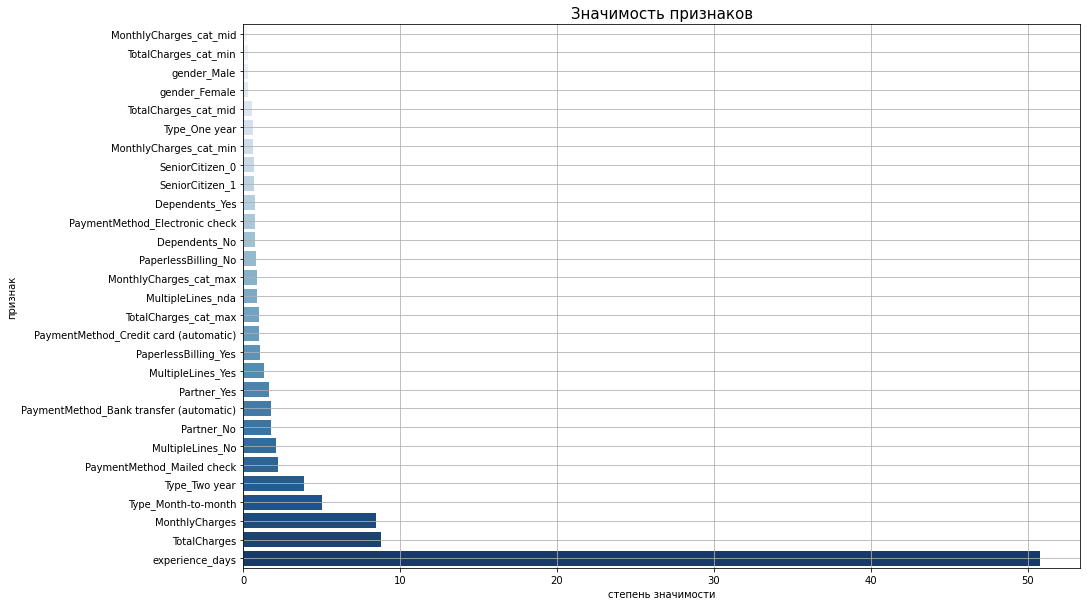

In [57]:
# Значимость признаков
best_model = model_cb.best_estimator_.feature_importances_
importance = pd.DataFrame(best_model, index=features_test.columns)

fig = plt.figure(figsize=(15,10))
sns.barplot(x=importance.sort_values(by=0).values.reshape((29,)),
                y=np.array(importance.sort_values(by=0).index), palette="Blues", saturation=0.70)
plt.grid(True)
plt.title('Значимость признаков', fontsize=15)
plt.ylabel('признак')
plt.xlabel('степень значимости');

### Вывод
Тестирование лучшей модели подтверждает ее качество и соответствует требованиям ТЗ, метрика AUC_ROC >= 0.85
Самым значимым параметром оказался срок контракта в днях, на втором месте общая сумма всех трат клиента, тройку лидеров замыкает месячные траты. Самыми незначительными признаками рказались дополнительно введеные категории общих и месячныз трат.


## Отчет

Какие пункты плана были выполнены, а какие — нет. Почему?

Какие трудности возникли и как вы их преодолели?

Какие ключевые шаги в решении задачи вы выделили?

Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

И так подведем итоги...
Планом предусматривалась следующая последовательность действий:
    
- [ ] Изучение исходных данных
- [ ] Вывод на основе исследования данных
- [ ] Предобработка данных
- [ ] Обработка данных перед расчетом модели(в том числе определение перечня актуальных признаков)
- [ ] Подбор и создание моделей(разбиение на выборки, , кодирование, выбор моделей, подбор гиперпараметров) 
- [ ] Тест выбранной модели  и ее анализ
- [ ] Вывод
- [ ] Отчет

Работа была проделана в соответтсвии с задуманным, все пункты были выполнены. 
Расскажу чуть подробнее. 
- Изучение данных. В нашем распоряжении было 4 датасета. 

`contract` содержит информацию о договрах. Он состоит из 8 колонок и 7043 строки. Пропущенных значений нет, один из цифровых столбцов  имеет строковый тип данных. Столбцы с датами преобразованы в тип данных на datime.

`internet` датасет с данными об использовании интернет-услуг. В данном датасете по сути все данные кроме customerID имеют булевое значение, то есть все 2 варианта ответа. Датасет состоит из 8 колонок и  5517 строк. Пропуски в данных отсутствуют, формат данных соответствует.

`personal` датасет с персональными данными клиента. Состоит из  5 колонок  и 7043 строк. Также как и у internet, данные имеют булевое значение. 

`phone` датасет с  данными об услугах телефонии, состоящий из 2 колонок и 6361 строк. Пропусков в данных не наблюдается.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020.

    ** BeginDate – дата начала пользования услугами
    ** EndDate – дата окончания пользования услугами
    ** Type – тип оплаты: ежемесячный, годовой и тд
    ** PaperlessBilling – безналичный расчет
    ** PaymentMethod – способ оплаты
    ** MonthlyCharges – ежемесячные траты на услуги
    ** TotalCharges – всего потрачено денег на услуги
    ** Dependents – наличие иждивенцев
    ** Senior Citizen – пенсионер(да/нет)
    ** Partner – семейный статус
    ** MultipleLines – наличие возможности ведения параллельных линий во время звонка

- Вывод на основе исследования данных. Датафреймы были объединены в единый большой датафрем путем вхождения всех данных(outer), вследствии чего появились пропуски. Пропуски в столбце `TotalCharges` заменены на значения из столбца `MonthlyCharges` исходя из логики, что меньше этой суммы общие траты быть не могут и возможно это первый месяц клиента, поэтому общие траты совпадают с месячными. Количетсво данных у нас немного, каждая строчка особенно ценна, поэтому остальные пропуски в булевых столбцах принято решение заменить на `nda`, что означает no data available(нет данных). Такое решение является оптимальным и не искозит картину поведения клиентов с теми или иными признаками. Таким образом в булевых столбцах, имеющих пропуски появилось третие значение. Построены графики распределения данных. Согласно графикам наблюдаем массовое открытие договоров в феврале 2014г, а закрытие договоров самое большое наблюдается с осени 2019 и плавно перетекает в зиму 2020г. Чаще всего клиенты оплачивают услуги помесячно  с использованием электронного чека. Услугами по онлайн защите большинство клиентов не пользуется. Помесячные траты и общие траты выглядят вполне правдоподобно: минимальный платеж в месяц 18.2, средний около 65 и максимальный 118.8.

- Предобработка данных и обработка данных перед расчетом модели(в том числе определение перечня актуальных признаков). На данном этапе работы был создан самый главный целевой признак, который позволяет определить с нами ли клиент или же безвозвратно нас покинул. Маркировка 1 соответствует действующему договору, 0 - закрытому. Также введен признак по длительности жизни клиента в компании в днях вплоть до дня выгрузки данных 1 февраля 2020. Созданы категории платежей min, mid, max для общих и помесячных платежей.
На этом же этапе планировалось ввести длительность жизни клиента в компании в месяцах. Однако построив график корреяции стало ясно, что данный признак имеет сильную зависимость от первообразующих столбцов, что отрицательно сказывается на качестве модели.
Были удалены столбцы, которые не нужны для дальнейшего построения модели `customerID`, `BeginDate`, `EndDate`, `experience`.

- Подбор и создание моделей(разбиение на выборки, кодирование, выбор моделей, подбор гиперпараметров). Данные поделены на выборки согласно ТЗ в соотношении 75% обучающая и 25% тестовая.  Обучающая выборка: (5282, 21) Тестовая выборка: (1761, 21). Построены графики распределения признаков в разрезе статуса договора, согласно графику сильных перекосов не наблюдается, данные выглядят вполне правдоподобно. Для дальнейшего построения модели категориальные признаки были закодированны. Для категориальных данных использовался OneHotEncoder(). Для того чтобы тестовые данные никак не влияли на обучающую часть используются  методы fit_transform для обучающей выборки, а для тестовой transform. Регрессионные не кодировались поскольку они числовые и нет смысла им присваивать сквозное числовое значение. Регрессионные признаки были просто присоединеныны к датасету с помощью join().
Проведен контроль датасета на колиниарность принаков. Признаки доп.услуг показали достаточно высокую зависимость. Для дальнейшей работы эти признакибыли удалены. Преднамеренно оставлены признаки категорий платежей общих и месячных, они показывают высокую корреляцию, что является логичным. Таким образом датасет был подготовлен к подбору моделей.


В качестве гиперпараметрический поиска оптимальной модели использовался RandomizedSearchCV(). Ппроверялись 4 модели:

- RandomForestClassifier с набором параметров  {'n_estimators': range (0, 200),
                                           'max_depth': [None, range (1,25)],
                                           'min_samples_leaf': range (1,25),
                                           'max_features': [None, 'sqrt', 'log2'] }
                                                
    лучшие параметры данной модели

    {'n_estimators': 45, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'max_depth': None}
    
       

- CatBoostClassifier с набором параметров  {'custom_loss': ['AUC', 'Accuracy'],
                                      'learning_rate': [0.01, 0.03, 0.02],
                                      'depth': range(1, 12)}

    лучшие параметры данной модели
    
    {'learning_rate': 0.03, 'depth': 5, 'custom_loss': 'AUC'}

- KNeighborsClassifier с набором параметров {'n_neighbors' : range(1,31),
                                        'weights': ['uniform', 'distance'],
                                        'algorithm': ['ball_tree', 'kd_tree', 'brute']}

    лучшие параметры данной модели
    
    {'weights': 'uniform', 'n_neighbors': 30, 'algorithm': 'ball_tree'}
    
    

- LogisticRegression с набором параметров {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

    лучшие параметры данной модели
    {'solver': 'newton-cg'}

Лучшей моделью оказалась CatBoostClassifier:

    Расчетное время обучения 746.91
    Гиперпараметры модели:
    {'learning_rate': 0.03, 'depth': 5, 'custom_loss': 'AUC'}
    Best Cross-Validation Score: 0.8724048104468334
    
При проверке на тестойвой выборке модель показала метрики согласно ТЗ, AUC_ROC превысил требуемый порог 0.85 :
    
    AUC_ROC: 0.9019625596476202
    ACC: 0.8989210675752414
    
    Матрица ошибок предсказаний сообщает нам, что количество истино-положительных решений значительно превышает ложно-отрицательных и ложно-положительных решений, что в свою очередь также говорит о высоком качестве модели
   

    
   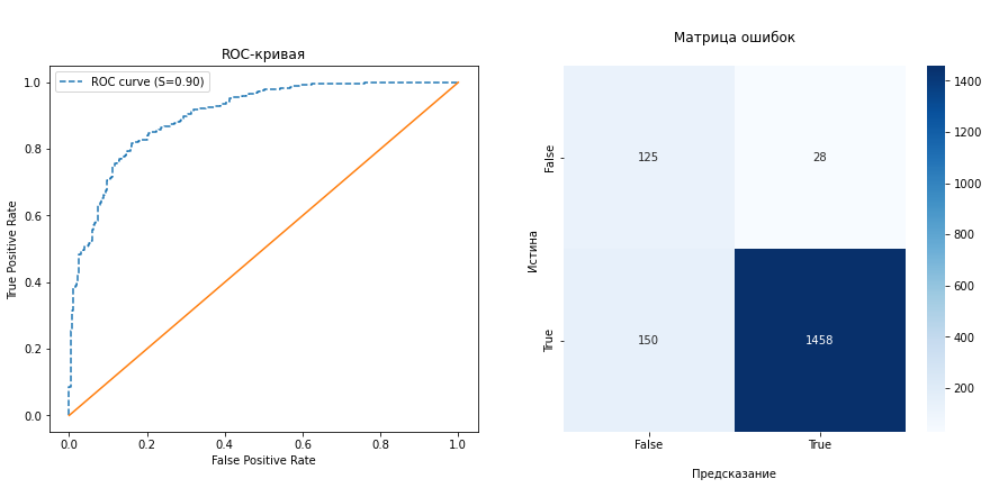
    
    
    
    
    
    
    


Для модели использовались следующие признаки:
    `Type_One year`                            
    `Type_Two year`                            
    `PaperlessBilling_No`                      
    `PaperlessBilling_Yes`                     
    `PaymentMethod_Bank transfer (automatic)`  
    `PaymentMethod_Credit card (automatic)`    
    `PaymentMethod_Electronic check`           
    `PaymentMethod_Mailed check`               
    `gender_Female`                            
    `gender_Male`                              
    `SeniorCitizen_0`                          
    `SeniorCitizen_1`                          
    `Partner_No`                               
    `Partner_Yes`                             
    `Dependents_No`                            
    `Dependents_Yes`                           
    `MultipleLines_No`                         
    `MultipleLines_Yes`                        
    `MultipleLines_nda`                        
    `MonthlyCharges_cat_max`                   
    `MonthlyCharges_cat_mid`                  
    `MonthlyCharges_cat_min`                   
    `TotalCharges_cat_max`                     
    `TotalCharges_cat_mid`                     
    `TotalCharges_cat_min`                     
    `MonthlyCharges`
    `TotalCharges`
    `experience_days`
    
В завершении исследования был проведен мониторинг значимости признаков

  
  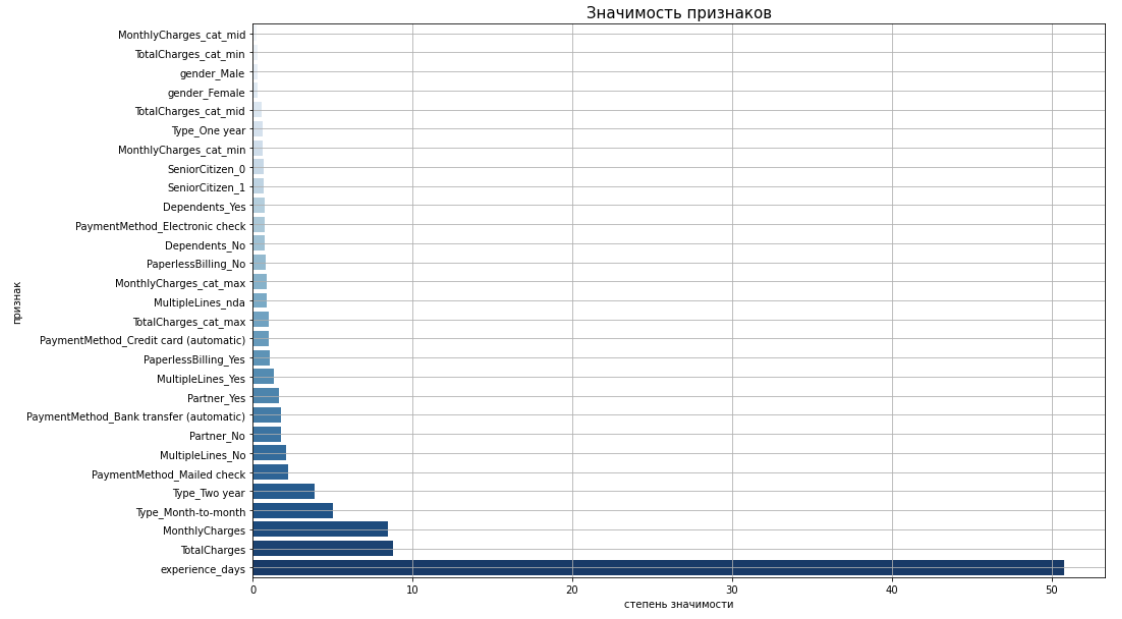